In [1]:
# Load FashionMNIST Dataset
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from custom_models import KCNN


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

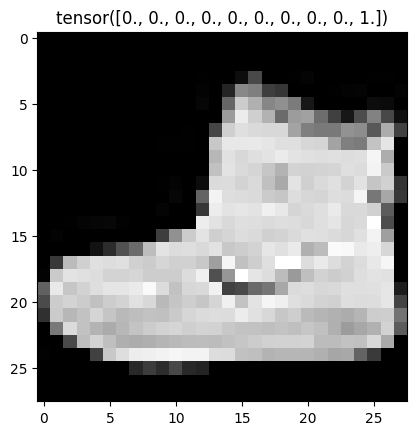

In [2]:
index = 0
img, label = training_data[index]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(label)
plt.show()

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device="cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
model = KCNN(28 * 28, 10, 3, 200).to(device)
print(model)

KCNN(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (intro): Sequential(
    (0): Linear(in_features=500, out_features=200, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=200, out_features=10, bias=True)
    (1): Softmax(dim=1)
  )
)


In [5]:
# Training loop
learning_rate = 1e-3
batch_size = 64
epochs = 10
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    t = tqdm(total = len(dataloader), position=1)
    with t as pbar:
        for batch, (X, y) in enumerate(dataloader):
            # Compute prediction and loss
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            if batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                pbar.set_description(f"\tTraining:\tloss: {loss:>4f}, curr: {current}")
            pbar.update(1)


def test_loop(dataloader, model, loss_fn, pbar):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    pbar.set_description(f"Epoch {pbar.n}:\tTest Error: (Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>4f}) \n")
    pbar.update(1)
    return test_loss, correct

In [27]:

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)
losses, corrects = [], []
p = tqdm(range(epochs), position=0, desc='Epoch 1...')
with p as pbar:
    for t in range(epochs):
        # print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        L, C = test_loop(test_dataloader, model, loss_fn, pbar)
        losses.append(L)
        corrects.append(C)
print("Done!")

	Training:	loss: 1.620124, curr: 57664: 100%|██████████| 938/938 [00:12<00:00, 75.00it/s]
Epoch 0:	Test Error: (Accuracy: 84.7%, Avg loss: 1.613992) 
Epoch 0:	Test Error: (Accuracy: 84.7%, Avg loss: 1.613992) 
	Training:	loss: 1.612383, curr: 57664: 100%|██████████| 938/938 [00:12<00:00, 75.04it/s]
Epoch 1:	Test Error: (Accuracy: 85.0%, Avg loss: 1.610764) 
Epoch 1:	Test Error: (Accuracy: 85.0%, Avg loss: 1.610764) 
	Training:	loss: 1.608627, curr: 57664: 100%|██████████| 938/938 [00:12<00:00, 77.26it/s]
Epoch 2:	Test Error: (Accuracy: 85.2%, Avg loss: 1.608155) 
Epoch 2:	Test Error: (Accuracy: 85.2%, Avg loss: 1.608155) 
	Training:	loss: 1.591908, curr: 57664: 100%|██████████| 938/938 [00:12<00:00, 76.25it/s]
Epoch 3:	Test Error: (Accuracy: 85.5%, Avg loss: 1.605251) 
Epoch 3:	Test Error: (Accuracy: 85.5%, Avg loss: 1.605251) 
	Training:	loss: 1.587747, curr: 57664: 100%|██████████| 938/938 [00:12<00:00, 75.79it/s]
Epoch 4:	Test Error: (Accuracy: 86.4%, Avg loss: 1.596570) 
Epoch 4:	T